# Setup

In [45]:
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS 
import sys
import os
import numpy as np
from PIL import Image
from textblob import TextBlob
import nltk
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from nltk.tokenize import word_tokenize
import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction

# Import Data

In [2]:
df = pd.read_csv("sms_scan_exit_survey.csv",keep_default_na=False) #leave blanks as blanks

###  dates take the place of subject labels
### Phrasing of question was changed after first six participants, much messier individual sequence responses for those first subjects, so I can either spend a bunch of time trying to organize that, or ignore those subjects, or just ignore individual sequences and merge across questions

In [3]:
df.head()

,Timestamp,"1. For each sequence, please characterize the strategies you used to remember the verbs.",2. Did you use verbal knowledge or experience (an event) to remember each sequence?,"3. In general, while making your responses, did you think of a singular event that occurred once at a particular time and place?","4. In general, while making your responses, did you think of a summary or merging of many similar or related events?","5. In general, while making your responses, did you think of a continuous event that occurred over an extended period of time lasting more than one day?",Unnamed: 6,Unnamed: 7
0,2017/07/26 2:14:42 PM MDT,,,"Yes, I thought of a singular event that the wo...",I didn't try to think of any similar events th...,"No, they were more like short segments sewed t...",,
1,2017/07/28 12:50:17 PM MDT,,,2/intact - no particular event\n3/scrambled - ...,"2/intact - yes very much, as this would be a c...","3/scrambled - no, this event in my head lasted...",No,No
2,2017/08/02 10:58:33 AM MDT,,,2 scrambled no\n3 random1 no\n4 intact no\n5 s...,2 scrambled yes\n3 random1 no\n4 intact no\n5 ...,2 scrambled no\n3 random1 yes\n4 intact yes\n5...,No problems.,I think that the problems I had were there on ...
3,2017/08/24 2:48:51 PM MDT,,,no for all,"yes for 2, 5, 6, 7, 9, 12, 13, 15 and no for t...","yes for 3, 4, 16 (kind of) and no for the rest",,"2, intact -- I realized that it was a basic d..."
4,2017/08/30 2:45:52 PM MDT,,,intact - 2 - No \n\nscramble - 3 - Yes; I ...,intact - 2 - Yes. I thought of my own experi...,intact - 2 - No\n\nscramble - 3 - No\n\nran...,No,No


In [4]:
# rename columns
df.columns = ['Subject','Q1','Q2','Q3','Q4','Q5','Q6','Q7']
# merge across questions, so all responses from each subject will be in one column
df['merged'] =  df.iloc[:, 1:].sum(axis=1)

# Look for between subject overall differences by building a tf-idf model from all subjects

In [5]:
# tokenize merged responses
df['tok_merged'] = [[w.lower() for w in word_tokenize(text)] 
            for text in df['merged']]

Mean # of tokens: 18467


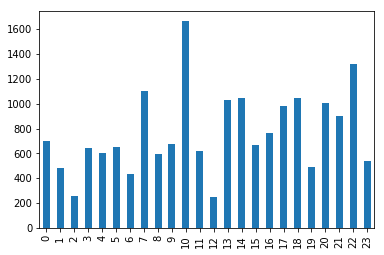

In [6]:
# plot number of tokens by subject
num_toks = df.tok_merged.apply(len)
print('Mean # of tokens:' ,np.sum(num_toks))
num_toks.plot(kind = 'bar')
plt.show()

In [7]:
# create dictionary
dictionary = gensim.corpora.Dictionary(df['tok_merged'])
# see how many words in the dictionary
len(dictionary)
# I would have thought there would be more unique words... I guess that's good? 

1847

In [8]:
# create a corpus 
corpus = [dictionary.doc2bow(x) for x in df['tok_merged']]
# creat tf-idf model of the corpus
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)

TfidfModel(num_docs=24, num_nnz=6034)


In [21]:
# creat similarlity object with gensim
# get path
cwd = os.getcwd()
sims = gensim.similarities.Similarity(cwd,tf_idf[corpus],
                                      num_features=len(dictionary))
print(sims)

Similarity index with 24 documents in 0 shards (stored under /Users/WBR/walter/python_psc290/hw)


In [10]:
# now create a query from one sub's responses by first bag of words-ing
query_doc_bow = dictionary.doc2bow(df['tok_merged'][1])
# then index tf_idf weights
query_doc_tf_idf = tf_idf[query_doc_bow]

In [11]:
sims[query_doc_tf_idf]

array([0.04068984, 1.0000002 , 0.15550756, 0.02335448, 0.11137828,
       0.05439073, 0.06243492, 0.05343318, 0.16747609, 0.14928679,
       0.06551225, 0.03037687, 0.00508134, 0.04148054, 0.05474997,
       0.0772889 , 0.02482655, 0.02682976, 0.034339  , 0.02597768,
       0.06060001, 0.02821321, 0.03432068, 0.05014485], dtype=float32)

In [20]:
sims.similarity_by_id

<bound method Similarity.similarity_by_id of <gensim.similarities.docsim.Similarity object at 0x1a1eac0b00>>

In [39]:
list(sims)[0]

array([0.999999  , 0.04068984, 0.0532045 , 0.0438494 , 0.1888521 ,
       0.07426773, 0.09896921, 0.13354322, 0.0614248 , 0.07154027,
       0.15344808, 0.12431833, 0.07758443, 0.251034  , 0.06363554,
       0.1644273 , 0.04082078, 0.07279146, 0.04689367, 0.0554514 ,
       0.11407172, 0.08240511, 0.08692756, 0.0948897 ], dtype=float32)

In [46]:
vect = TfidfVectorizer(min_df=1)
tfidf = vect.fit_transform(corpus)

AttributeError: 'list' object has no attribute 'lower'